# Heston Model

https://quantecon.org/

On sait que $dS = rS + \sigma SdW_t$. Ma volatilité suit elle aussi un processus stochastic ainsi nous avons (real world measure $\mathbb{P}$):
$$\large dS_t = \mu S_tdt + \sqrt{v_t}S_tdW_{S,t}^\mathbb{P}$$
$$\large dv_t = \kappa(\theta - v_t)dt + \sigma \sqrt{v_t}dW_{v,t}^\mathbb{P}$$

Avec:  
- $v_t$ ma variance ainsi $\sqrt{v_t}$ est ma vol
- $\sigma$ la vol de vol
- $\theta$ variance moyenne
- $\kappa$ vitesse de retour à la moyenne
- $\rho$ correlation entre mes 2 mouvements brownien

Under risk-neutral measure $\mathbb{Q}$:  
$$\large dS_t = rS_tdt + \sqrt{v_t}S_tdW_{S,t}^\mathbb{Q}$$
$$\large dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt + \sigma^\mathbb{Q} \sqrt{v_t}dW_{v,t}^\mathbb{Q}$$


https://frouah.com/finance%20notes/Euler%20and%20Milstein%20Discretization.pdf  
  
En appliquant la méthode d'Euler:  
$$\large dS_{i+1} = S_ie^{(r-\frac{v_i}{2})\Delta t+ \sqrt v_i \Delta t W^\mathbb{Q}_{S,i+1}}$$
$$\large v_{i+1} = v_i + \kappa(\theta-v_i)\Delta t +\sigma\sqrt v_i\Delta t W^\mathbb{Q}_{v,i+1}$$

Le problème est que je peux avoir des nombres négatifs pour $v_t$

In [1]:
from ModuleFinance import *

c:\Program64\Python\Python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
Udl = MarketData(100, 0.2, 0.05, 0.02)
MC = MonteCarlo(Udl, 2, 252, 1_000)

kappa = 3  			#vitesse de retour à la moyenne
theta = 0.20**2     #moyenne
v0 = 0.40**2        #variance_ini  
sigma = 0.6			#vol de vol
rho = 0			#correl

In [3]:
def cholesky_decomposition(matrice: np.ndarray) -> np.ndarray:
    if matrice.shape == (2,2):
        a = 1
        b = matrice[0,1]
        c = np.sqrt(1 - b**2)
        return np.array([[a,0],[b,c]])
    raise IndexError(f"la fonction: {__name__} ne surporte que les matrices 2*2.")

def BivariateStantardDistribution_generate(rho: float):
    vecteur_random = [np.random.normal(), np.random.normal()]
    L = cholesky_decomposition(np.array([[1, rho],[rho, 1]]))
    return [L@vecteur_random]

class BivariateStantardDistribution:    
    def generate(rho: float):
        vecteur_random = [np.random.normal(), np.random.normal()]
        L = cholesky_decomposition(np.array([[1, rho],[rho, 1]]))
        return L@vecteur_random

In [4]:
class MonteCarlo:
    def __init__(self, Udl: MarketData, T: float, NB_Pas: int, NB_Simu: int) -> None:
        self.S = float(Udl.Spot)
        self.Vol = float(Udl.Vol)
        self.r = Udl.get_rate(T)
        self.q =float(Udl.Div)
        self.Date = Udl.Date
        self.T = float(T)
        self.N = int(NB_Pas)
        self.M = int(NB_Simu)
           
    def stantard(self, correl: float, variance: float, kappa:float, theta:float, vol_vol:float) -> np.ndarray:
        return Stantard(self.S, self.Vol, self.r, self.q, self.T, self.N, self.M, correl, variance, kappa, theta, vol_vol)

@njit(parallel=True, fastmath=True, nogil=True)
def Stantard(S: float, Vol: float, r: float, q: float, T: float, N: int, M: int, rho:float, v0:float, kappa:float, theta:float, vol_vol:float) -> np.ndarray:
	Longeur = int((N * T) + 1)
	spot_array = np.zeros((M, Longeur), dtype=float)
	variance_array = np.zeros((M, Longeur), dtype=float)
	dt = 1/N

	for i in prange(M):
		spot_array[i, 0] = S
		variance_array[i, 0] = v0
		for J in range(1, Longeur):
			drift = ((r - q) - variance_array[i, J-1]/2) * dt
			diffusion = np.sqrt(variance_array[i, J-1]*dt)
			
			z1, z2 = np.random.normal(), np.random.normal()
			z2 = (z1*rho + np.sqrt(1 - rho**2)*z2)
			
			spot_array[i, J] = spot_array[i, J - 1] * np.exp(drift + diffusion*z1)
			variance_array[i, J] = np.maximum(variance_array[i, J-1] + kappa*(theta - variance_array[i, J-1])*dt + vol_vol*np.sqrt(variance_array[i, J-1]*dt)*z2,0)
	return spot_array, variance_array


In [29]:
df_spot, df_var = MonteCarlo(Udl, 1, 100, 10_000).stantard(rho,v0,kappa,theta,sigma)
df_spot

array([[100.        , 105.63611213, 104.47286174, ...,  81.49650876,
         81.69210205,  83.54124636],
       [100.        ,  92.6099668 ,  92.74406877, ..., 107.80259243,
        105.70171795, 107.18270601],
       [100.        , 104.11674497, 104.16734806, ...,  70.80652951,
         73.20869152,  70.86718331],
       ...,
       [100.        ,  97.99770761, 100.83617111, ...,  99.62424596,
        100.29372458, 101.1744387 ],
       [100.        ,  91.97292806,  87.90560641, ...,  63.44545483,
         66.2697905 ,  68.01996993],
       [100.        ,  99.97410849,  98.73439978, ...,  97.7990668 ,
         96.66205993, 100.12705483]])

## Graphe Vol sto

In [7]:
import matplotlib.pyplot as plt

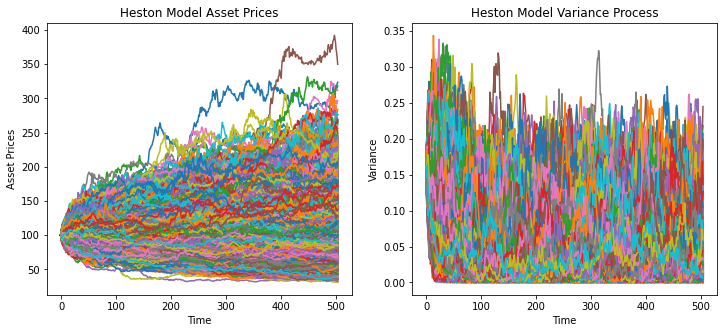

In [28]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(df_spot.T)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
ax2.plot(df_var.T)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
plt.show()

In [5]:
df_high_coorel, _ = MonteCarlo(Udl, 1, 252, 1_000_000).stantard(0.80,v0,kappa,theta,sigma)
df_low_coorel, _ = MonteCarlo(Udl, 1, 252, 1_000_000).stantard(-0.80,v0,kappa,theta,sigma)
df_high_coorel, df_low_coorel = pd.DataFrame(df_high_coorel),pd.DataFrame(df_low_coorel)

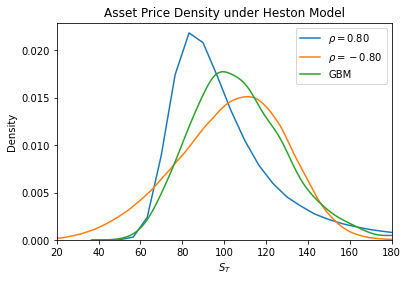

In [8]:
# simulate gbm process at time T
import seaborn as sns
gbm = 100*np.exp( (0.05 - theta**2/2)*1 + np.sqrt(theta)*np.sqrt(1)*np.random.normal(0,1,1000) )
fig, ax = plt.subplots()
ax = sns.kdeplot(df_high_coorel[252], label=r"$\rho= 0.80$", ax=ax)
ax = sns.kdeplot(df_low_coorel[252], label=r"$\rho= -0.80$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)
plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

***On peut voir que j'ai un problème avec la corrélation j'ai donc un soucis dans mes maths.***

## Détail différente Formule

Rappel ma distribution bivarié est comme suit: $Lv+\mu$. Comme je suis une loi normal centré alors $\mu$ est 0 et v est généré aléatoirement. Anisi il ne me reste qu'a calculer $Lv$.  

$$
\begin{pmatrix}
\sqrt{a} & 0 \\
\frac{b}{a} & (c^2-b^2)
\end{pmatrix}
*
\begin{pmatrix}
random_1 \\
random_2
\end{pmatrix}
=
\begin{pmatrix}
new rand_1 \\
new rand_2
\end{pmatrix}
$$

Ma matrice de covariance est:  
$$
\begin{pmatrix}
1 & \rho \\
\rho & 1
\end{pmatrix}
$$  
  
Ainsi:  
$$
\begin{pmatrix}
\sqrt{1} & 0 \\
\frac{\rho}{1} & (1^2-\rho^2)
\end{pmatrix}
*
\begin{pmatrix}
random_1 \\
random_2
\end{pmatrix}
=
\begin{pmatrix}
new rand_1 \\
new rand_2
\end{pmatrix}
$$  
  
Ainsi:  
$$
\begin{pmatrix}
1 & 0 \\
\rho & (1-\rho^2)
\end{pmatrix}
*
\begin{pmatrix}
random_1 \\
random_2
\end{pmatrix}
=
\begin{pmatrix}
new rand_1 \\
new rand_2
\end{pmatrix}
$$  
  
Ainsi:  
$$
\begin{pmatrix}
1*random_1 + 0*random_2 \\
\rho*random_1 + (1-\rho^2)*random_2
\end{pmatrix}
=
\begin{pmatrix}
new rand_1 \\
new rand_2
\end{pmatrix}
$$  
  
Ainsi:  
$$
\begin{pmatrix}
random_1 \\
\rho*random_1 + (1-\rho^2)*random_2
\end{pmatrix}
=
\begin{pmatrix}
new rand_1 \\
new rand_2
\end{pmatrix}
$$

## Random number generator

Comme numba ne support pas de la fonction np.random.multivariate_normal(), je vais devoir la fonctoion à la main.

### Rappel single random normal

In [10]:
import matplotlib.pyplot as plt
import numpy as np

On comment avec la fonction $e^x$:  
$\large y = e^x$

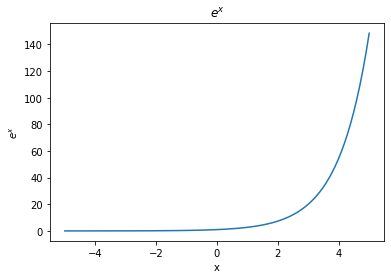

In [11]:
x = np.linspace(-5, 5, 100)
y = np.exp(x)
plt.plot(x, y)
plt.title('$e^x$')
plt.xlabel('x')
plt.ylabel('$e^x$')
plt.show()

Si on passe le tout au carré on obtient:  
$\large y =e^{x^2}$

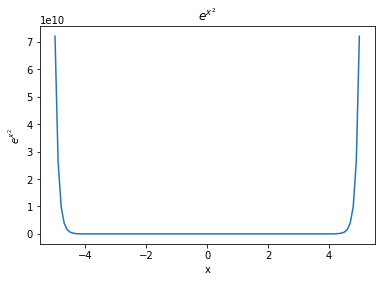

In [12]:
x = np.linspace(-5, 5, 100)
y = np.exp(x**2)
plt.plot(x, y)
plt.title('$e^{x^2}$')
plt.xlabel('x')
plt.ylabel('$e^{x^2}$')
plt.show()

On place un moins devant mon exposant afin d'obtenir une cloche:  
$\large y = e^{-x^2}$

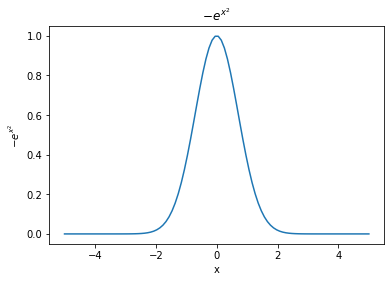

In [13]:
x = np.linspace(-5, 5, 100)
y = np.exp(-x**2)
plt.plot(x, y)
plt.title('$-e^{x^2}$')
plt.xlabel('x')
plt.ylabel('$-e^{x^2}$')
plt.show()

On peut choisir sur quel x la cloche est centré en soustrayant $\mu$ à $x$. Ci dessous pour $\mu$ = 2. C'est la "mean" de ma distribution:  
$\large y = e^{-(x-\mu)^2}$

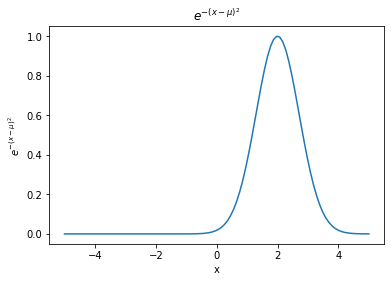

In [14]:
mu = 2
x = np.linspace(-5, 5, 100)
y = np.exp(-(x-mu)**2)
plt.plot(x, y)
plt.title('$e^{-(x-\mu)^2}$')
plt.xlabel('x')
plt.ylabel('$e^{-(x-\mu)^2}$')
plt.show()

On peut controler la largeur de ma cloche en multipliant $x$ par un constante ici $\sigma$:  
$\large y = e^{-(\sigma x)^2}$

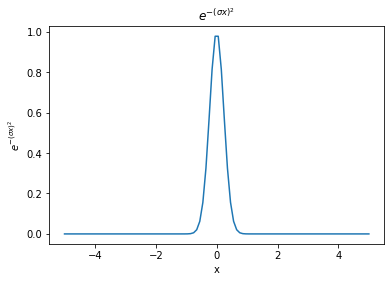

In [15]:
sigma = 3
x = np.linspace(-5, 5, 100)
y = np.exp(-(sigma*x)**2)
plt.plot(x, y)
plt.title('$e^{-(\sigma x)^2}$')
plt.xlabel('x')
plt.ylabel('$e^{-(\sigma x)^2}$')
plt.show()

Le problème est que plus sigma est large plus ma cloche est serré ainsi on multiple par $\frac {1}{\sigma}$:  
$\large y = e^{\large -(\frac {x}{\sigma})^2}$

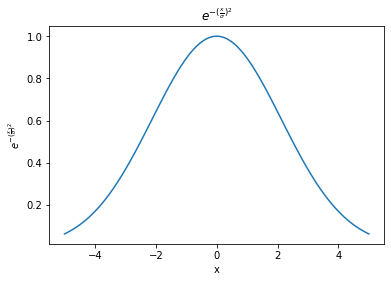

In [16]:
sigma = 3
x = np.linspace(-5, 5, 100)
y = np.exp(-(x/sigma)**2)
plt.plot(x, y)
plt.title(r'$e^{-(\frac {x}{\sigma})^2}$')
plt.xlabel('x')
plt.ylabel(r'$e^{-(\frac {x}{\sigma})^2}$')
plt.show()

On multiplie le tout par $\frac {1}{2}$ afin non seulement d'avoir un dérivié pour clean mais pour que mes points d'inflexion (from concave to convexe) soit à $\sigma$ au lieu d'être $\frac {\sigma}{\sqrt 2}$. l'inflection point passe de $e^{-x^2}$ à $e^{-\frac{1}{2}x^2}$:  
$\large y = e^{\large -\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

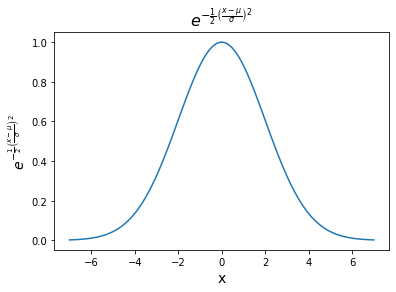

In [17]:
sigma = 2
mu = 0
x = np.linspace(-7, 7, 100)
y = np.exp(-0.5*((x-mu)/sigma)**2)
plt.plot(x, y)
plt.title(r'$e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel(r'$e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$', fontsize=14)
plt.show()

La dernière étape est de rentre l'air de ma cloche égale à 1 en toute circonstance pour ça:  
$\int_{-\infty}^{\infty} e^{\large -\frac{1}{2}(\frac{x-\mu}{\sigma})^2} = \color{red}\sigma \sqrt{2\pi}$  
ainsi en multipliant le tout par $\frac{1}{\sigma \sqrt{2\pi}}$ je normalise le tout.  
$\large y = \color{red}\frac{1}{\sigma \sqrt{2\pi}} \color{default}e^{\large -\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$  
Le term pour normalisé ne contient pas la moyenne car cette dernière ne modifie pas l'aire mais uniquement l'emplacement tandis que $\sigma$ modifie bien l'aire

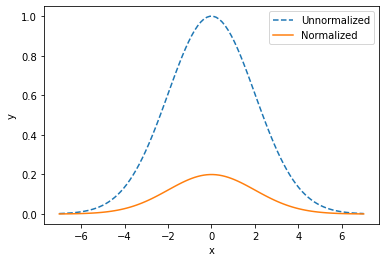

In [18]:
sigma = 2
mu = 0
x = np.linspace(-7, 7, 100)
not_normelized = np.exp(-0.5*((x-mu)/sigma)**2)
normalized = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-mu)/sigma)**2)
plt.plot(x, not_normelized, linestyle='--', label="Unnormalized")
plt.plot(x, normalized, label="Normalized")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Multivariate Normal Distribution

La multivariate nomal distriution $X\sim N(\mu,\sum)$ est paramètre de $\mu$ qui est le mean vector et $\sum$ qui est la covariance matrice.  
la probability density function (pdf) d'une multivariate de $d$ est:  
  
$$y = \frac{1}{\sqrt{|{\Sigma}|(2\pi)^d}}e^{\large -\frac{1}{2}(x-\mu)\sum ^{-1}(x-\mu)'}$$
avec $|{\Sigma}|$ qui est le déterminant de la matrice  
  
avec $x$ et $\mu$ qui sont des vecteurs 1d et $\sum$ est une matrice carré $d$

La matrice $\sum$ possède la variance sur ça diagonal et la correlation dans le reste. ainsi pour une correl de 0 nous avons:  
$$\Sigma = \left(\begin{array}{cccc}\sigma^2_1 & 0 & \dots & 0\\ 0 & \sigma^2_2 & \dots & 0\\ \vdots & \vdots & \ddots & \vdots\\ 0 & 0 & \dots & \sigma^2_p \end{array}\right)$$  



#### Bivariate Normal Distribution

https://online.stat.psu.edu/stat505/book/export/html/636

Si on cherche la multivariate normal distribution pour 2 variables nous avons:  
$$\left(\begin{array}{c}X_1\\X_2 \end{array}\right) \sim N \left[\left(\begin{array}{c}\mu_1\\ \mu_2 \end{array}\right), \left(\begin{array}{cc}\sigma^2_1 & \rho \sigma_1\sigma_2 \\ \rho\sigma_1\sigma_2 & \sigma^2_2 \end{array}\right)\right]$$  
  
Mon déterminant :$$|\Sigma| = \sigma^2_1\sigma^2_2(1-\rho^2)$$
  
Avec l'inverse de ma covariance matrice:  $$\Sigma^{-1} = \dfrac{1}{\sigma^2_1\sigma^2_2(1-\rho^2)} \left(\begin{array}{cc}\sigma^2_2 & -\rho \sigma_1\sigma_2 \\ -\rho\sigma_1\sigma_2 & \sigma^2_1 \end{array}\right)$$  
  
Sachant que : $$\phi(x_1,x_2) = \frac{1}{\sqrt{|{\sum}|(2\pi)^d}}e^{\large -\frac{1}{2}(x-\mu)\sum ^{-1}(x-\mu)'}$$

Dans mon cas on sait que $\sigma ^2_1 , \sigma ^2_2 = 1$. Ainsi:  
$$|\Sigma| = (1-\rho^2)$$
$$\Sigma^{-1} = \dfrac{1}{(1-\rho^2)} \left(\begin{array}{cc}1 & -\rho \\ -\rho & 1 \end{array}\right)$$
  
Sachant que $d=2$:
$$\phi(x_1,x_2) = \frac{1}{(2\pi)\sqrt{(1-p^2)}}e^{\large -\frac{1}{2(1-p^2)}(\color{red}[x_1^2 - 2px_1x_2 + x_2^2]\color{default})}$$

la partie rouge viens d'internet vérifier soit même

In [19]:
def bivariate_normal(x1,x2, correl):
    mutliplicateur = 1/((2*np.pi)*np.sqrt((1-correl)**2))
    tow_pie_power = -(1/(2*((1-correl)**2)))
    exposant2 = x1**2 - 2*correl*x1*x2 + x2**2
    return mutliplicateur * np.exp(tow_pie_power*exposant2)

Pour créer ma Bivariate Normal en partant de 2 valeurs normal je peux les générer, puis je modifie mon plan avec le vecteur $L$ tel que $\Sigma = LL^T$. Ainsi mon vecteur multivarié est: $$Lv + u$$

In [20]:
def cholesky_decomposition(matrice) -> np.ndarray:
    if matrice.shape == (2,2):
        a = 1
        b = matrice[0,1]
        c = np.sqrt(1 - b**2)
        return [[a,0],[b,c]]
    raise IndexError(f"la fonction: {__name__} ne surporte que les matrices 2*2.")

In [38]:
class BivariateStantardDistribution:    
    def generate(rho: float):
        vecteur_random = [np.random.normal(), np.random.normal()]
        L = cholesky_decomposition(np.array([[1, rho], [rho, 1]]))
        # L = cholesky_decomposition(np.array([[1, rho], [rho, 1]]))
        return (np.array(L)@vecteur_random).tolist()

In [39]:
BivariateStantardDistribution.generate(0.99)

[-0.7123808772085091, -0.680350353665178]

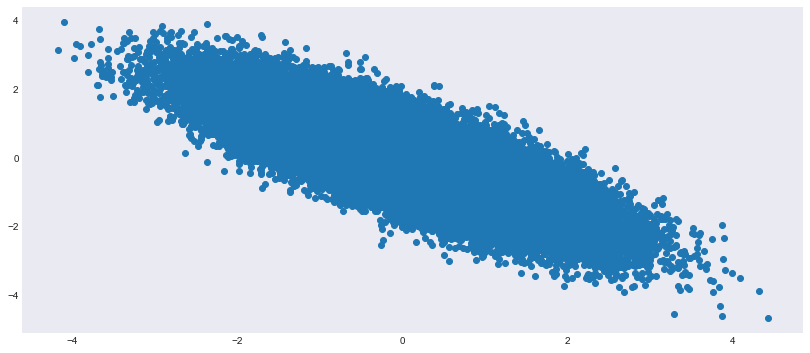

In [97]:
from scipy.stats import multivariate_normal

correlation = -0.80
sample_size = 100000
mean = np.zeros(2)
cov = [[1, correlation], [correlation, 1]]
rv = multivariate_normal(mean, cov)
samples = rv.rvs(sample_size)
fig, ax = plt.subplots()
ax.scatter(samples[:, 0], samples[:, 1])
plt.show()

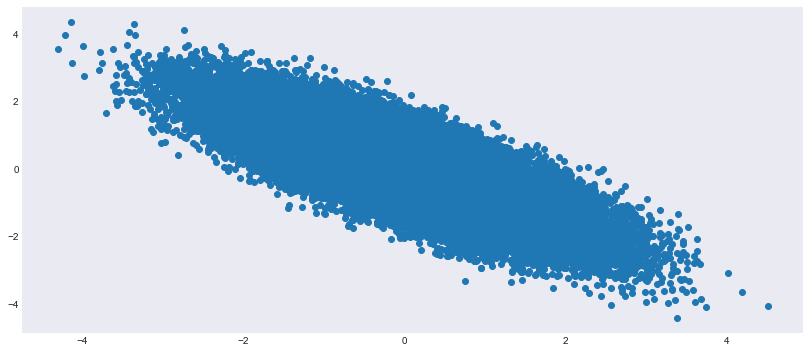

In [98]:
sample = []
rho = -0.80
for i in range(sample_size):
	z1, z2 =np.random.normal(), np.random.normal()
	z2 = (z1*rho + np.sqrt(1 - rho**2)*z2)
	sample.append([z1, z2])
sample = np.array(sample)
fig, ax = plt.subplots()
ax.scatter(sample[:, 0], sample[:, 1])
plt.show()

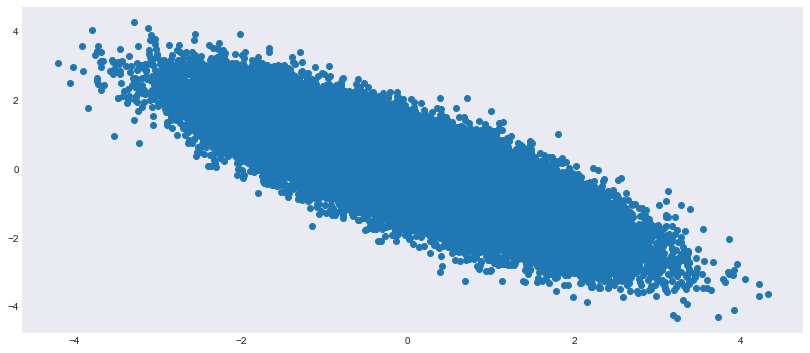

In [99]:
sample = []
for i in range(sample_size):
	sample.append(BivariateStantardDistribution.generate(rho))
sample = np.array(sample)
fig, ax = plt.subplots()
ax.scatter(sample[:, 0], sample[:, 1])
plt.show()


In [62]:
mean = np.array([0,0])
cov = [[1, 0.8], [0.8, 1]]

%timeit BivariateStantardDistribution.generate(0.8)
%timeit multivariate_normal(mean, cov).rvs(1)
%timeit np.random.multivariate_normal(mean,cov)

44.2 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
567 µs ± 168 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
141 µs ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


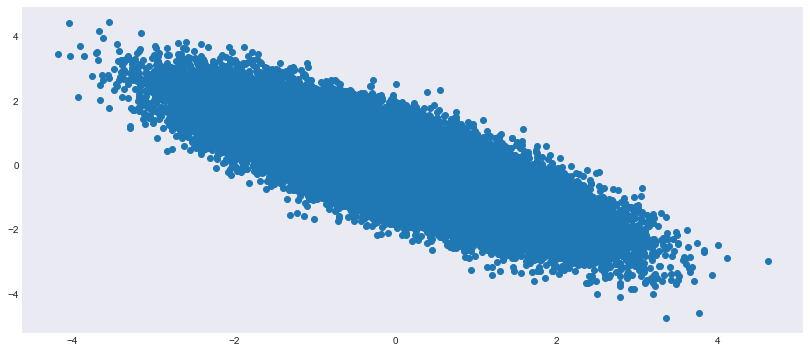

In [100]:
def generate_bivariate_normal_samples(correlation):
    z1, z2 =np.random.normal(), np.random.normal()
    z2 = (correlation * z1 + np.sqrt(1 - correlation**2) * z2)
    return [z1, z2]

sample = []
for i in range(sample_size):
	sample.append(generate_bivariate_normal_samples(-0.8))
sample = np.array(sample)
fig, ax = plt.subplots()
ax.scatter(sample[:, 0], sample[:, 1])
plt.show()

Ma méthode est la plus rapide je dis ça je dis rien.

#### Décomposition de cholesky

Pour généré ma matrice de covariance je vais avoir besoin de réaliser une décomposition de cholesky. Cette décomposition fonctionne uniquement pour les matrices **symétriques et définie positive**. Elle transforme la matrice $A$ en une lower diagonal matrice $L$ tel que $A = LL^T$.  
Afin d'éviter les racines carrées il y a une décomposition alternative tel que $A = LDL^T$ avec $D$ ma matrice diagonal.

Exemple de $A = LL^T$:  
$$
\begin{pmatrix}
4 & 12 & -16 \\
12 & 37 & -43 \\
-16 & -43 & 98
\end{pmatrix}
=
\begin{pmatrix}
2 & 0 & 0 \\
6 & 1 & 0 \\
-8 & 5 & 3
\end{pmatrix}
\begin{pmatrix}
2 & 6 & -8 \\
0 & 1 & 5 \\
0 & 0 & 3
\end{pmatrix}
$$  

Exemple de $A = LDL^T$.  
$$
\begin{pmatrix}
4 & 12 & -16 \\
12 & 37 & -43 \\
-16 & -43 & 98
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 \\
3 & 1 & 0 \\
-4 & 5 & 1
\end{pmatrix}
\begin{pmatrix}
4 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 9
\end{pmatrix}
\begin{pmatrix}
1 & 3 & -4 \\
0 & 1 & 5 \\
0 & 0 & 1
\end{pmatrix}
$$

La décomposition de Cholesky permet nottament de transformer un cercle en ellipsoid. si on image un plan avec un cercle on va le modifier afin de transformer mon cercle: on va garder le premier vecteur $\hat{i}$ parrallèle à son axe et modifer le second vecteur $\hat{j}$ afin de modifier son aire. Ainsi Cholesky permet de modifier ma distribution normal multivarié. Cholesky permet aussi de résoudre des système linéaire.

Dans nos cas nous allons réfléchir à comment résoudre ça dans une matrice 2x2.  
$$
\begin{pmatrix}
a & 0 \\
b & c
\end{pmatrix}
\begin{pmatrix}
a & b \\
0 & c
\end{pmatrix}= 
\begin{pmatrix}
a^2 & ab \\
ab & (b^2 + c^2)
\end{pmatrix}
$$  

Ansi ma décomposition L sera:  
$$
\begin{pmatrix}
\sqrt{a} & 0 \\
\frac{b}{a} & (c^2-b^2)
\end{pmatrix}
$$

Cependant je prefère evitér d'utiliser $\sqrt{}$ sur un float donc si j'y arrive je vais faire ma $LDL^T$. Flemme de le faire on va rester sur notre $A = LL^T$

In [26]:
def cholesky_decomposition(matrice) -> np.ndarray:
    if matrice.shape == (2,2):
        a = 1
        b = matrice[0,1]
        c = np.sqrt(1 - b**2)
        return np.array([[a,0],[b,c]])
    raise IndexError(f"la fonction: {__name__} ne surporte que les matrices 2*2.")

In [27]:
rho = 0.94
cov = np.array([[1, rho],
                [rho, 1]])
cholesky_decomposition(cov)

array([[1.        , 0.        ],
       [0.94      , 0.34117444]])